# Data processing/plotting

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import re

## Magnetoresistance in Cr<sub>1-x</sub>Mo<sub>x</sub>O<sub>2</sub>

MRR data were taken from https://doi.org/10.1109/TMAG.2005.854825.

Phase stability data were extracted from the introduction of https://doi.org/10.1016/j.jssc.2009.03.025 (references cited within).

In [79]:
MRR = pd.read_csv('../files/_CrMo_O2_magneto_resistance_data.csv', names=['x','MR (%)'])

MRR

,x,MR (%)
0,-0.000091,5.566265
1,0.050046,5.620482
2,0.099875,4.201807
3,0.200062,3.894578
4,0.298653,1.951807
5,0.400000,1.201807
6,0.799546,0.225904
7,1.000000,0.000000


In [80]:
phase_limits = [
    ('MoO2', (0.0, 0.12), {'fL':0.0}),
    ('CrO2', (0.12, 0.36)),
    ('CrMoO4', (0.36, 0.5)),
    ('Cr2MoO6', (0.667, 0.667)),
    ('CrO2', (1.0, 1.0), {'fR':0.0, 'fL':0.05}),
]

In [81]:
# Reusable fuzzy region renderer
import numpy as _np
import matplotlib.colors as _mcolors

def _coerce_regions(regions):
    out = []
    if isinstance(regions, dict):
        items = [(k, v) for k, v in regions.items()]
    else:
        items = regions
    for item in items:
        if isinstance(item, dict):
            name = str(item['name'])
            if 'range' in item:
                x0, x1 = item['range']
            else:
                x0, x1 = item['x_min'], item['x_max']
            fL = float(item.get('fL', _np.nan))
            fR = float(item.get('fR', _np.nan))
            out.append({'name': name, 'x_min': float(x0), 'x_max': float(x1), 'fL': fL, 'fR': fR})
        elif isinstance(item, (list, tuple)):
            if len(item) == 3 and not isinstance(item[1], (list, tuple)):
                # (name, x0, x1)
                name, x0, x1 = item
                out.append({'name': str(name), 'x_min': float(x0), 'x_max': float(x1), 'fL': _np.nan, 'fR': _np.nan})
            elif len(item) >= 2 and isinstance(item[1], (list, tuple)):
                # (name, (x0,x1)) or (name,(x0,x1),{...})
                name, rng = item[:2]
                x0, x1 = rng
                fL = _np.nan
                fR = _np.nan
                if len(item) >= 3 and isinstance(item[2], dict):
                    fL = float(item[2].get('fL', _np.nan))
                    fR = float(item[2].get('fR', _np.nan))
                out.append({'name': str(name), 'x_min': float(x0), 'x_max': float(x1), 'fL': fL, 'fR': fR})
        else:
            raise ValueError('Unsupported region specification: %r' % (item,))
    # sort by x_min
    out.sort(key=lambda d: d['x_min'])
    return out


def render_fuzzy_regions(
    ax,
    regions,
    x_limits,
    y_limits,
    global_fuzz=0.06,
    alpha_base=0.5,
    n_x=1500,
    cmap_name='tab10',
    label=True,
    use_mhchem=False,
    label_ypos=0.88,
):
    """Render soft-edged colored regions along x with white gaps.

    Parameters
    - ax: matplotlib Axes
    - regions: list/dict of regions; each region can include optional 'fL'/'fR' (fractions of x-span)
    - x_limits: (xmin, xmax)
    - y_limits: (ymin, ymax)
    - global_fuzz: default fuzz fraction if fL/fR not given
    - alpha_base: base opacity within regions
    - n_x: resolution along x for blending
    - cmap_name: base colormap for phase colors
    - label: whether to draw labels
    - use_mhchem: True to wrap labels in \ce{...} (requires LaTeX setup)
    - label_ypos: relative height (0..1) for labels
    """
    x0, x1 = x_limits
    y0, y1 = y_limits
    x_span = max(float(x1 - x0), _np.finfo(float).eps)
    x_range = _np.linspace(x0, x1, int(n_x))

    regs = _coerce_regions(regions)
    P = len(regs)
    if P == 0:
        return None

    # Resolve per-region fuzz L/R with global fallback
    for r in regs:
        if _np.isnan(r['fL']):
            r['fL'] = float(global_fuzz)
        if _np.isnan(r['fR']):
            r['fR'] = float(global_fuzz)

    # Determine shared boundaries and averaged fuzz for contiguous neighbors
    eps = 1e-9 * x_span
    shared_left_w = [None] * P   # width fraction for left boundary if shared
    shared_right_w = [None] * P  # width fraction for right boundary if shared
    for i in range(P - 1):
        li = regs[i]
        ri = regs[i + 1]
        if abs(li['x_max'] - ri['x_min']) <= eps:
            w_avg = 0.5 * (li['fR'] + ri['fL'])
            shared_right_w[i] = w_avg
            shared_left_w[i + 1] = w_avg

    # Build per-region soft masks
    smoothstep = lambda t: t * t * (3 - 2 * t)
    weights = _np.zeros((P, x_range.size), dtype=float)

    for i, r in enumerate(regs):
        x_min = r['x_min']
        x_max = r['x_max']
        # widths in absolute x-units
        wL = (shared_left_w[i] if shared_left_w[i] is not None else r['fL']) * x_span
        wR = (shared_right_w[i] if shared_right_w[i] is not None else r['fR']) * x_span

        if _np.isclose(x_min, x_max):
            # single-point feature: use average of L/R or a small floor
            w = max(0.5 * (wL + wR), 1e-8)
            left = x_min - 0.5 * w
            right = x_min + 0.5 * w
            t = _np.clip((x_range - left) / (right - left), 0.0, 1.0)
            tri = _np.minimum(smoothstep(t), smoothstep(1.0 - t)) * 2.0
            weights[i, :] = _np.clip(tri, 0.0, 1.0)
            continue

        left_in = x_min + 0.5 * wL
        left_out = x_min - 0.5 * wL
        right_in = x_max - 0.5 * wR
        right_out = x_max + 0.5 * wR

        w = _np.zeros_like(x_range)
        # Left ramp 0→1
        lm = (x_range >= left_out) & (x_range < left_in)
        if _np.any(lm):
            tL = (x_range[lm] - left_out) / max((left_in - left_out), 1e-12)
            w[lm] = smoothstep(tL)
        # Core 1.0
        cm = (x_range >= left_in) & (x_range <= right_in)
        w[cm] = 1.0
        # Right ramp 1→0
        rm = (x_range > right_in) & (x_range <= right_out)
        if _np.any(rm):
            tR = (right_out - x_range[rm]) / max((right_out - right_in), 1e-12)
            w[rm] = smoothstep(tR)
        weights[i, :] = _np.clip(w, 0.0, 1.0)

    # Normalize where any region applies
    sum_w = weights.sum(axis=0)
    valid = sum_w > 1e-8
    w_norm = _np.zeros_like(weights)
    w_norm[:, valid] = (weights[:, valid] / sum_w[None, valid])

    # Color mapping by name (stable across repeats)
    names = [r['name'] for r in regs]
    uniq = []
    for n in names:
        if n not in uniq:
            uniq.append(n)
    base_colors = _np.array(plt.get_cmap(cmap_name).colors)
    cmap = {n: base_colors[i % len(base_colors)] for i, n in enumerate(uniq)}
    colors = _np.array([cmap[n] for n in names])

    # Compose RGBA image
    rgb_mix = (w_norm.T @ colors)
    alpha_profile = _np.zeros_like(sum_w)
    alpha_profile[valid] = alpha_base * _np.clip(sum_w[valid], 0.0, 1.0)

    img = _np.ones((100, len(x_range), 4), dtype=float)
    img[..., :3] = rgb_mix[None, :, :]
    img[..., 3] = alpha_profile[None, :]

    ax.set_facecolor('white')
    ax.imshow(
        img,
        extent=[x0, x1, y0, y1],
        aspect='auto',
        origin='lower',
        interpolation='bilinear',
        zorder=1,
    )

    # Labels
    if label:
        import re as _re
        def _format_formula(label: str, use_mhchem: bool = False) -> str:
            s = str(label)
            if use_mhchem:
                return r'$\\ce{' + s + '}$'
            parts = []
            pattern = _re.compile(r'([A-Za-z]+|\(|\)|\[|\])([0-9]*)')
            pos = 0
            for m in pattern.finditer(s):
                if m.start() > pos:
                    raw = s[pos:m.start()]
                    if raw:
                        parts.append(r'\mathrm{' + raw + '}')
                token, digits = m.group(1), m.group(2)
                parts.append(r'\mathrm{' + token + '}')
                if digits:
                    parts.append(r'_{' + digits + '}')
                pos = m.end()
            if pos < len(s):
                raw = s[pos:]
                parts.append(r'\mathrm{' + raw + '}')
            return r'$' + ''.join(parts) + '$'

        y_pos = y0 + label_ypos * (y1 - y0)
        for r in regs:
            xc = r['x_min'] if _np.isclose(r['x_min'], r['x_max']) else 0.5 * (r['x_min'] + r['x_max'])
            if not (x0 <= xc <= x1):
                continue
            txt = _format_formula(r['name'], use_mhchem)
            ax.text(
                xc, y_pos, txt,
                ha='center', va='center', fontsize=11, color='black', zorder=4,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
            )

    return {'names': names, 'color_map': {n: cmap[n] for n in uniq}, 'x_range': x_range}


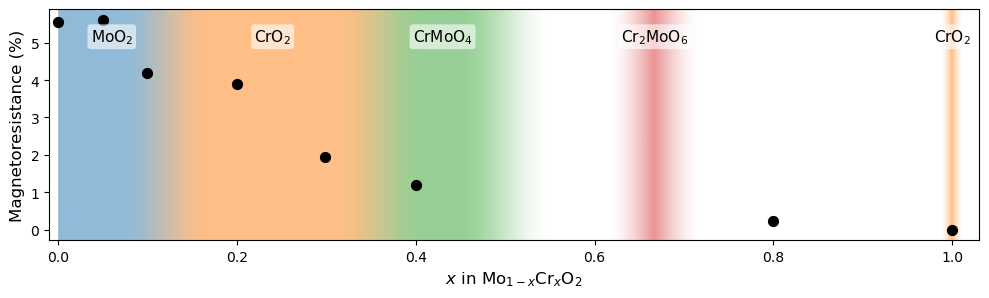

In [84]:
fig, ax = plt.subplots(figsize=(12, 3))

# Plot scatter points on top
ax.scatter(MRR['x'], MRR['MR (%)'], s=50, color='black', zorder=3)


# x/y limits from plot
x_limits = (-0.01,1.03)
y_limits = ax.get_ylim()

# Prepare regions: support list or dict forms; allow optional fL/fR per region
regions = phase_limits  # reuse as-is; helper will coerce

# Render fuzzy regions with global fuzz and per-edge overrides when provided
render_fuzzy_regions(
    ax,
    regions=regions,
    x_limits=x_limits,
    y_limits=y_limits,
    global_fuzz=0.1,   # default fuzz fraction if a region doesn't specify fL/fR
    alpha_base=0.5,
    n_x=1500,
    cmap_name='tab10',
    label=True,
    use_mhchem=False,
    label_ypos=0.88,
)


ax.set_xlabel('$x$ in Mo$_{1-x}$Cr$_x$O$_2$', fontsize=12)
ax.set_ylabel('Magnetoresistance (%)', fontsize=12)
#ax.set_title('Magnetoresistance in Cr$_{1-x}$Mo$_x$O$_2$', fontsize=13)
#ax.grid(True, alpha=0.3)
plt.show()

fig.savefig('../images/MoCrO2_magnetoresistance_phases.png', bbox_inches='tight')